#TensorFlow Image Classification Tutorial:
https://www.tensorflow.org/tutorials/images/classification?hl=ko

Data: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
data_dir = pathlib.Path('Combined Dataset')

In [ ]:
train_image_count = len(list(data_dir.glob('train/*/*.jpg')))
test_image_count = len(list(data_dir.glob('test/*/*.jpg')))

print(train_image_count)
print(test_image_count)

10240
1279


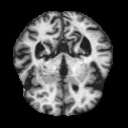

In [ ]:
train_nots = list(data_dir.glob('train/No Impairment/*'))
Image.open(str(train_nots[0])) #<class 'pathlib.WindowsPath'> 이므로 문자열로 변환해야 함.

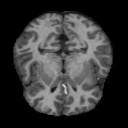

In [ ]:
Image.open(str(train_nots[1]))

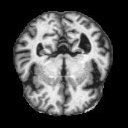

In [ ]:
train_Mild = list(data_dir.glob('train/Mild Impairment/*'))
Image.open(str(train_Mild[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_dir = pathlib.Path('Combined Dataset/train')

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, # 학습 데이터 경로
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, # 학습 데이터 경로
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10240 files belonging to 4 classes.
Using 8192 files for training.
Found 10240 files belonging to 4 classes.
Using 2048 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


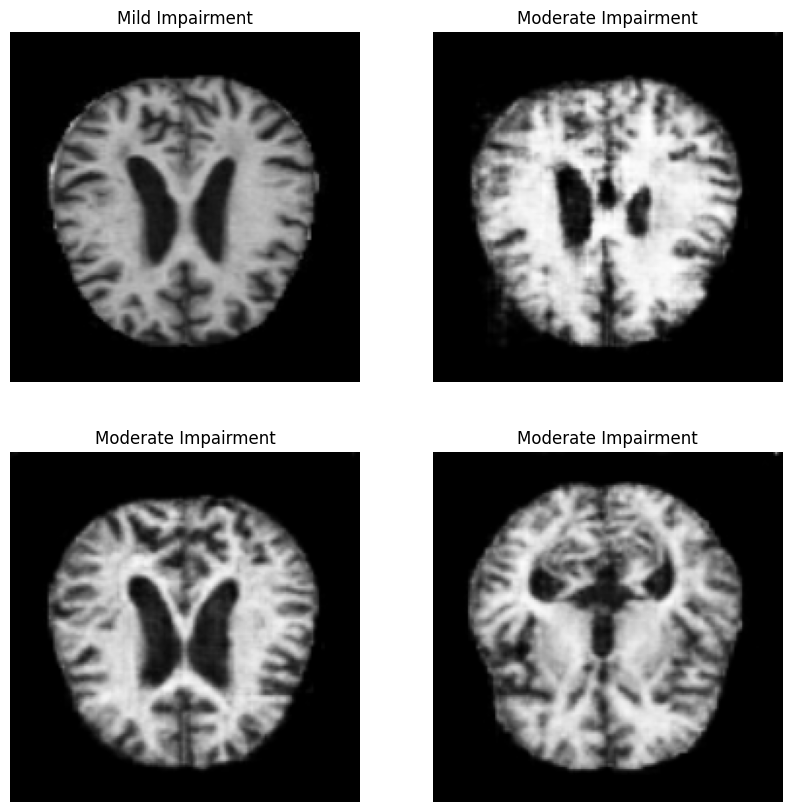

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(type(image_batch))
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32,)


In [ ]:
#cache(): 처음 로딩 후 메모리(또는 지정한 파일)에 저장합니다. 이를 통해 매 에포크마다 디스크에서 다시 데이터를 불러오는 시간을 줄일 수 있습니다.

#shuffle(1000): 1000개씩 데이터를 임의로 섞어 학습 데이터의 순서에 따른 편향이 없도록 합니다.

#prefetch(buffer_size=AUTOTUNE): 데이터가 모델에 입력되기 전에 다음 배치를 미리 준비하여, 데이터 전처리와 모델 학습이 동시에 이루어지도록 합니다. AUTOTUNE을 사용함으로써 최적의 prefetch 버퍼 크기를 텐서플로우가 자동으로 설정합니다.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#데이터 표준화하기


RGB 채널 값은 [0, 255] 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다.

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9737996


In [ ]:
#기본 케라스 모델
#조정 가능

num_classes = len(class_names)

model = Sequential([
    keras.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
     layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10
#history는 학습 과정 동안의 기록(log)을 담고 있는 객체입니다.
#model은 fit() 함수를 통해 실제로 학습된 모델입니다.

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 52s 199ms/step - accuracy: 0.5470 - loss: 1.0282 - val_accuracy: 0.8550 - val_loss: 0.3608
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 201ms/step - accuracy: 0.8579 - loss: 0.3507 - val_accuracy: 0.8779 - val_loss: 0.2926
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 56s 218ms/step - accuracy: 0.9151 - loss: 0.2179 - val_accuracy: 0.9355 - val_loss: 0.1694
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 55s 216ms/step - accuracy: 0.9501 - loss: 0.1300 - val_accuracy: 0.9551 - val_loss: 0.1278
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.9697 - loss: 0.0808 - val_accuracy: 0.9463 - val_loss: 0.1386
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 197ms/step - accuracy: 0.9766 - loss: 0.0607 - val_accuracy: 0.9634 - val_loss: 0.0909
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 63s 246ms/step - accuracy: 0.9805 - loss: 0.0516 - val_accuracy: 0.9678 - val_loss: 0.1060
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 58s 229ms/step - accuracy: 0.9816 - loss: 0

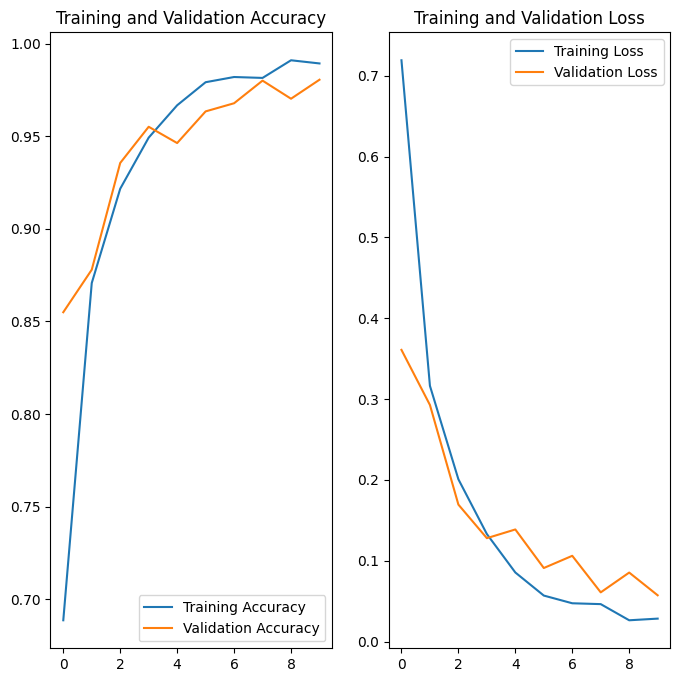

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_dir =  pathlib.Path('Combined Dataset/test')

#하위 test 데이터셋들 하나로 모음
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 1279 files belonging to 4 classes.


In [ ]:
# 모델 평가 (손실값과 정확도 반환)
loss, accuracy = model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9378 - loss: 0.1730
Test loss: 0.10652962327003479
Test accuracy: 0.958561360836029


In [ ]:
# 전체 테스트 데이터셋에 대해 예측을 수행합니다.
predictions = model.predict(test_ds)
# 각 이미지에 대해 예측한 클래스 인덱스를 결정합니다.
predicted_class_indices = np.argmax(predictions, axis=1)

# 테스트 데이터셋의 실제 라벨을 추출합니다.
# test_ds는 (이미지, 라벨) 튜플을 반환합니다.
ground_truth = []
for images, labels in test_ds:
    ground_truth.extend(labels.numpy())
ground_truth = np.array(ground_truth)

# 클래스 이름 리스트 (tf.keras.utils.image_dataset_from_directory 사용 시 자동 생성됨)
class_names = test_ds.class_names

# 예측한 클래스 이름과 실제 클래스 이름으로 변환합니다.
predicted_class_names = [class_names[i] for i in predicted_class_indices]
actual_class_names = [class_names[i] for i in ground_truth]

#csv 파일로 예측 클래스와 실제 클래스 저장
df = pd.DataFrame({'actual': actual_class_names, 'predict': predicted_class_names})


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


In [ ]:
df.head()

,actual,predict
0,Mild Impairment,Mild Impairment
1,Mild Impairment,Mild Impairment
2,Mild Impairment,Mild Impairment
3,Mild Impairment,Mild Impairment
4,Mild Impairment,Mild Impairment


In [ ]:
df.to_csv("result.csv", index=False)